# Imports (global)

In [133]:
!conda env list

# conda environments:
#
                         /home/yves/Documents/GitHub/ReactionClasses/.conda
                         /home/yves/Documents/Projects/hello/.conda
base                     /home/yves/anaconda3
MultiStepRetro        *  /home/yves/anaconda3/envs/MultiStepRetro
MultiStepRetro1.4        /home/yves/anaconda3/envs/MultiStepRetro1.4
MultiStepRetrotest       /home/yves/anaconda3/envs/MultiStepRetrotest
aizynth-env              /home/yves/anaconda3/envs/aizynth-env
aizynthtrain             /home/yves/anaconda3/envs/aizynthtrain
casp_env                 /home/yves/anaconda3/envs/casp_env
cookiecutter             /home/yves/anaconda3/envs/cookiecutter
enz_trans                /home/yves/anaconda3/envs/enz_trans
graph2smiles             /home/yves/anaconda3/envs/graph2smiles
graphormerhf             /home/yves/anaconda3/envs/graphormerhf
graphretrosynthesis      /home/yves/anaconda3/envs/graphretrosynthesis
mypackaging              /home/yves/anaconda3/envs/mypackaging
onmtggn

In [74]:
import pandas as pd
from statistics import mean

# import rdkit components
from rdkit import rdBase
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdChemReactions

# use IPythonConsole for pretty drawings
from rdkit.Chem.Draw import IPythonConsole

## The next line is commented out 
### because GitHub does not render svg's embedded in notebooks
# IPythonConsole.ipython_useSVG=True
IPythonConsole.ipython_useSVG=False

# for flattening tuples and lists
from itertools import chain

from tqdm import tqdm
import ttlretro
from ttlretro.rxnmarkcenter import RXNMarkCenter
rxnmarkcenter = RXNMarkCenter()
from ttlretro.single_step_retro import SingleStepRetrosynthesis
singlestepretrosynthesis = SingleStepRetrosynthesis()


Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/yves/anaconda3/envs/MultiStepRetro/lib/python3.8/site-packages/rxnmapper/models/transfo

# Imports (template datasets)

In [4]:
#templates
#temp_r0 = pd.read_csv('/home/yves/Documents/GitHub/CASP-and-dataset-performance/outputs/amol_USPTO_templates_set_r0_v2.csv', header=None)
#temp_r0.columns = ["ind","ID", "reaction_hash", "reactants", "products", "classification","retro_template", "template_hash", "selectivity", "outcomes"]

#formatted version of temp_r0 can be directly loaded:
temp_r0 = pd.read_pickle('/home/yves/Documents/GitHub/USPTO_balance/data/amol_USPTO_templates_set_r0_v2_formatted.pkl')
failtemp_r0 = pd.read_csv('/home/yves/Documents/GitHub/CASP-and-dataset-performance/outputs/amol_USPTO_templates_set_r0_v2_failed.csv', header=None)

#original mapped uspto data
df_amol = pd.read_pickle('/home/yves/Documents/GitHub/ForwardTag/data/df_Thakkar_04_2023_Mapped.pkl')

#round trip accuracy on test set data
rta_df = pd.read_pickle('/home/yves/Documents/GitHub/ForwardTag/MultiStepRetrosynthesisTTL/df_RTA_results_full_test_set.pkl')

In [6]:
#Comparing template_hash r0
templates_hash_r0 =     temp_r0['template_hash'].value_counts().index.to_list()
appearances_hash_r0 =   temp_r0['template_hash'].value_counts()
perc_hash_r0 =          temp_r0['template_hash'].value_counts()/len(temp_r0) *100

In [3]:
#check that no reaction has been forgotten
len(temp_r0) + len(failtemp_r0), len(temp_r0)/2, len(temp_r0)/(len(temp_r0) + len(failtemp_r0)) * 100 

(1266730, 594818.0, 93.91393588215327)

# Add rxnfp reaction classification (not done)

---- rxnfp environment ----

In [3]:
import pandas as pd
import pkg_resources
from rxnfp import rxnfp
#from rxnfp.models import SmilesClassificationModel


ModuleNotFoundError: No module named 'rxnfp'

In [ ]:
temp_r0 = pd.read_csv('CASP-and-dataset-performance/outputs/amol_USPTO_templates_r0_v1.csv', header=None)
temp_r0.columns = ["ind","ID", "reaction_hash", "reactants", "products", "classification","retro_template", "template_hash", "selectivity", "outcomes"]
failtemp_r0 = pd.read_csv('CASP-and-dataset-performance/outputs/amol_USPTO_templates_r0_v1_failed.csv', header=None)

In [ ]:
#Load trained model (trained with steps 1-5)
train_model_path =  pkg_resources.resource_filename("rxnfp", "models/transformers/bert_class_1k_tpl")

model = SmilesClassificationModel("bert", train_model_path, use_cuda=torch.cuda.is_available())

In [ ]:
#Predictions on test set

#test data will be the 50 first reactions from USPTO 
test_df = pd.read_csv('../USPTO/2001_Sep2016_USPTOapplications_smiles.rsmi', sep='\t' , header=0, )
test_df = test_df['ReactionSmiles'][0:49].values.tolist()

y_preds = model.predict(test_df)#.text.values)

# RDkit tutorial on template application

https://github.com/rdkit/rdkit-tutorials/blob/master/notebooks/003_SMARTS_ReactionsExamples.ipynb

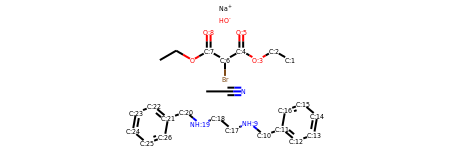

In [31]:
#Reactants
Chem.MolFromSmiles(temp_r0.at[0, 'reactants'])

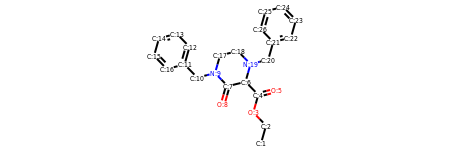

In [33]:
#Product
Chem.MolFromSmiles(temp_r0.at[0, 'products'])

In [34]:
#Reaction template
temp_r0.at[0, 'retro_template']

'([N;H0;D3;+0:3]-[CH;D3;+0:1]-[C;H0;D3;+0:2]-[N;H0;D3;+0:4])>>(Br-[CH;D3;+0:1]-[C;H0;D3;+0:2]-O-C-C).([NH;D2;+0:3].[NH;D2;+0:4])'

In [35]:
#Use the template to define a retrosynthetic reaction
rxn_1 = AllChem.ReactionFromSmarts(temp_r0.at[0, 'retro_template'])

In [36]:
#Apply the retrosynthetic reaction on a given product and obtain a tuple containing the precursors 
rxn_1.RunReactants((Chem.MolFromSmiles(temp_r0.at[0, 'products']),))

((<rdkit.Chem.rdchem.Mol at 0x7f1f0ae54870>,
  <rdkit.Chem.rdchem.Mol at 0x7f1f0ae547c0>),)

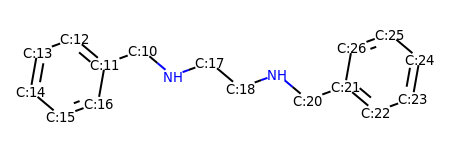

In [41]:
#Precursors 
rxn_1.RunReactants((Chem.MolFromSmiles(temp_r0.at[0, 'products']),))[0][1]

# 0. Count the template occurences and find to what reactions they are associated (introduction)

### 0.0.0 Formatting of dataframes (original match up between RTA results reactions and original uspto dataframe)

In [ ]:
#run both imports before this section

In [4]:
#temp_r0 formatting (done)

#remove ind column which is useless
temp_r0.drop(columns=['ind'], inplace=True)
#replace ID by the set of the reaction TRAIN, TEST, or VAL
temp_r0['Set'] = [temp_r0.at[i, 'ID'].split(';')[1] for i in range(len(temp_r0))]
#add mapped reaction column
temp_r0['MAPPED_SMILES'] = [temp_r0.at[i, 'ID'].split(';')[0] for i in range(len(temp_r0))]
#drop the ID column
temp_r0.drop(columns=['ID'], inplace=True)

In [5]:
#isolate df_amol_test_set just to be sure
df_amol_test_set = df_amol[df_amol['Set'] == 'TEST']

#add df_amol['product] column that contains the unmapped RHS of the reaction (prod column contains the mapped version)
df_amol_test_set['product'] = [df_amol_test_set['Reaction'].iloc[i].split('>>')[1] for i in range(len(df_amol_test_set))]

/tmp/ipykernel_2635770/3869528698.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_amol_test_set['product'] = [df_amol_test_set['Reaction'].iloc[i].split('>>')[1] for i in range(len(df_amol_test_set))]


In [61]:
#save appropriate format of temp_r0
temp_r0.to_pickle('/home/yves/Documents/GitHub/CASP-and-dataset-performance/results/amol_USPTO_templates_set_r0_v2_formatted.pkl')

In [6]:
#temp_r0 contains the templates of the supposed reaction paths, let's add on the subset of test set the predicted reactions, mapped reactions, and then the extracted templates of those reactions
temp_r0_test_set = temp_r0[temp_r0['Set'] == 'TEST']

In [12]:
#obtain the unmapped reactions 
from multiprocessing import Pool

dataset = temp_r0_test_set['MAPPED_SMILES'].values
processes = 14
def remove_mapping(smi):
    try:
        rxn = rdChemReactions.ReactionFromSmarts(smi, useSmiles=True)
        return rxnmarkcenter.remove_mapping(rxn)
    except: return ''
if __name__ == '__main__':
   with Pool(processes) as p:
      output = list(tqdm(p.imap(remove_mapping, dataset), total = len(dataset)))

#add it to the dataframe-----
temp_r0_test_set['unmapped_reacton'] = output

100%|██████████| 59591/59591 [00:07<00:00, 7953.48it/s]


In [17]:
#find the product of the unmapped reaction
temp_r0_test_set['product'] = [temp_r0_test_set['unmapped_reaction'].iloc[i].split('>>')[1] for i in tqdm(range(len(temp_r0_test_set)))]

100%|██████████| 59591/59591 [00:00<00:00, 209137.00it/s]
/tmp/ipykernel_2635770/2141228324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_r0_test_set['product'] = [temp_r0_test_set['unmapped_reacton'].iloc[i].split('>>')[1] for i in tqdm(range(len(temp_r0_test_set)))]


In [26]:
#add predicted reactivity (from round trip accuracy) to the template dataframe
ref = rta_df['target'].to_list()
canonical_predictions = []
for i in tqdm(range(len(temp_r0_test_set))):
    try:
        ind = ref.index(temp_r0_test_set['product'].values[i])
        canonical_predictions.append(rta_df.at[ind, 'canonical_prediction_1'])
    except:
        canonical_predictions.append('')
        continue
len(canonical_predictions)

#add it to the dataframe
temp_r0_test_set['canonical_prediction_1'] = canonical_predictions

100%|██████████| 59591/59591 [00:15<00:00, 3909.96it/s]


59591

In [35]:
#add predicted (by TTL) reactivity to the template dataframe
temp_r0_test_set['pred_reaction'] = [temp_r0_test_set['canonical_prediction_1'].iloc[i] + '>>' + temp_r0_test_set['product'].iloc[i] for i in range(len(temp_r0_test_set))]

/tmp/ipykernel_2635770/3537793608.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_r0_test_set['pred_reaction'] = [temp_r0_test_set['canonical_prediction_1'].iloc[i] + '>>' + temp_r0_test_set['product'].iloc[i] for i in range(len(temp_r0_test_set))]


In [44]:
#map the predicted reactions 
mapped_pred_rxns = list(rxnmarkcenter.rxn_mapper_batch.map_reactions(temp_r0_test_set['pred_reaction']))

In [45]:
#add it to the dataframe
temp_r0_test_set['mapped_pred_rxns'] = mapped_pred_rxns
temp_r0_test_set['mapped_pred_rxns'].to_csv('/home/yves/Documents/GitHub/CASP-and-dataset-performance/outputs/amol_USPTO_templates_set_r0_v2_full.csv')

/tmp/ipykernel_2635770/4189272263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_r0_test_set['mapped_pred_rxns'] = mapped_pred_rxns


In [46]:
#format and save the mapped predicted reactions to a csv file and extract templates from them
df_test = pd.DataFrame()
df_test['rsmi']         =  temp_r0_test_set['mapped_pred_rxns']
df_test['patent_id']    =  temp_r0_test_set['mapped_pred_rxns'] #for backup
df_test['para_num']     =  0
df_test['year']         =  2023 
df_test['classification'] = '' 
df_test['text_yield']   =  0 
df_test['calc_yield']   =  0 
df_test.to_csv('/home/yves/Documents/GitHub/CASP-and-dataset-performance/data-hiding-place/rta_pred_reactions.csv', index=False)

### 0.0.1 Add predicted templates to the test set dataframe

In [49]:
#compare the templates that were supposed to be predicted with the templates that were actually predicted
df_pred_temp = pd.read_csv('/home/yves/Documents/GitHub/CASP-and-dataset-performance/outputs/rta_test_set_templates.csv')
df_pred_temp.columns = ["ind","ID", "reaction_hash", "reactants", "products", "classification","retro_template", "template_hash", "selectivity", "outcomes"]

#df_pred_temp formatting
#remove ind column which is useless
df_pred_temp.drop(columns=['ind'], inplace=True)
#add mapped reaction column
df_pred_temp['MAPPED_SMILES'] = [df_pred_temp.at[i, 'ID'].split(';')[0] for i in range(len(df_pred_temp))]
#drop the ID column
df_pred_temp.drop(columns=['ID'], inplace=True)

In [55]:
#add predicted reactivity (from round trip accuracy) to the template dataframe
ref = df_pred_temp['MAPPED_SMILES'].to_list()
pred_template_hash = []
for i in tqdm(range(len(temp_r0_test_set))):
    try:
        ind = ref.index(temp_r0_test_set['mapped_pred_rxns'].values[i])
        pred_template_hash.append(df_pred_temp.at[ind, 'template_hash'])
    except:
        pred_template_hash.append('')
        continue
len(pred_template_hash)

#add it to the dataframe
temp_r0_test_set['pred_template_hash'] = pred_template_hash

100%|██████████| 59591/59591 [00:35<00:00, 1690.62it/s]
/tmp/ipykernel_2635770/3829754584.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_r0_test_set['pred_template_hash'] = pred_template_hash


In [59]:
#save dataframe
temp_r0_test_set.to_pickle('/home/yves/Documents/GitHub/CASP-and-dataset-performance/results/amol_USPTO_templates_set_r0_v2_testset_preds.pkl')


### 0.0.2 Prepare data for Plot frequency of template in train set vs percentage of accurate template predictions in test set

In [2]:
# load the full template file (train, test, val with all mapped reactions, etc)
temp_r0 = pd.read_pickle('/home/yves/Documents/GitHub/CASP-and-dataset-performance/results/amol_USPTO_templates_set_r0_v2_formatted.pkl')
#load the full template test set file
temp_r0_test_set = pd.read_pickle('/home/yves/Documents/GitHub/CASP-and-dataset-performance/results/amol_USPTO_templates_set_r0_v2_testset_preds.pkl')

In [78]:
#first go through unique expected templates and find their number, and the percentage of accurate predictions
nummatches = []
perc = []
len_temp = []
for i in tqdm(range(len(temp_r0_test_set['template_hash'].unique()))):
    tempdf = temp_r0_test_set[temp_r0_test_set['template_hash'] == temp_r0_test_set['template_hash'].unique()[i]]
    match =sum([tempdf['pred_template_hash'].values[j] == tempdf['template_hash'].values[j] for j in range(len(tempdf))])
    perc.append( match/len(tempdf) )
    nummatches.append(match)
    len_temp.append(len(tempdf))

100%|██████████| 13235/13235 [01:49<00:00, 120.65it/s]


In [81]:
#find the number of apparitions of each template in the training set
temp_r0_train_set = temp_r0[temp_r0['Set'] == 'TRAIN']

num_app_train = []
for i in tqdm(range(len(temp_r0_test_set['template_hash'].unique()))):
    num_app_train.append(len(temp_r0_train_set[temp_r0_train_set['template_hash'] == temp_r0_test_set['template_hash'].unique()[i]]))

100%|██████████| 13235/13235 [08:03<00:00, 27.36it/s]


In [ ]:
#save in dataframe
pd.DataFrame({'#matches':nummatches, '#perc':perc, 'num_app_train':num_app_train, 'len_temp':len_temp}).to_pickle('/home/yves/Documents/GitHub/CASP-and-dataset-performance/results/testset_plot_data_001.pkl')

## 0.1 Determine the top 20 most frequent reaction template hashes in USPTO

In [29]:
#goal is to print successively examples of the 20 most common templates in the dataset
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
from PIL import Image


In [100]:
len(temp_r0)

1189636

In [113]:
len(appearances_hash_r0)

137500

### 0.1.1 List of 3 reactions from each of the top 20 most common template hashes

In [61]:
df_top20 = pd.DataFrame(['reac', 'prod', 'rxn'])
reac = []
prod = []
rxn = []
for i in range(20):
#    reac.append([Chem.MolFromSmiles(temp_r0[temp_r0['template_hash'] == templates_hash_r0[i]]['reactants'].iloc[j]) for j in range(3)])
#    prod.append([Chem.MolFromSmiles(temp_r0[temp_r0['template_hash'] == templates_hash_r0[i]]['products'].iloc[j]) for j in range(3)])
    reac.append([temp_r0[temp_r0['template_hash'] == templates_hash_r0[i]]['reactants'].iloc[j] for j in range(3)])
    prod.append([temp_r0[temp_r0['template_hash'] == templates_hash_r0[i]]['products'].iloc[j] for j in range(3)])
for i in range(len(reac)):
    for j in range(3):
        rxn.append(reac[i][j] + '>>' + prod[i][j])

### 0.1.2 Top 1 reaction template // Amide bond formation (COOH + NX2H -> CONX2)

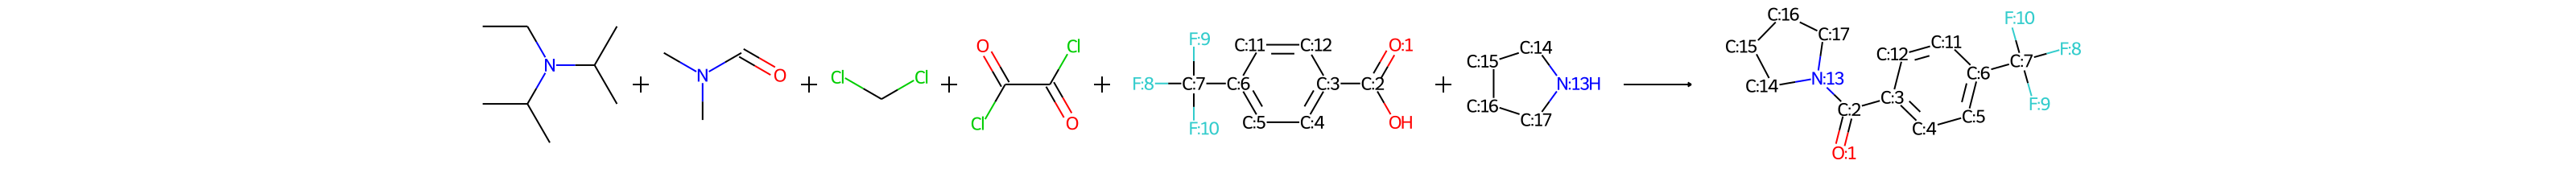

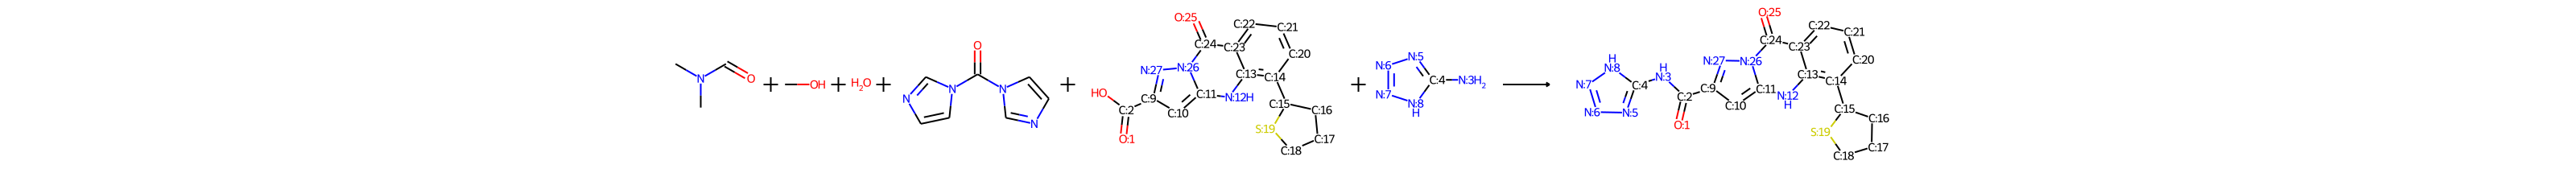

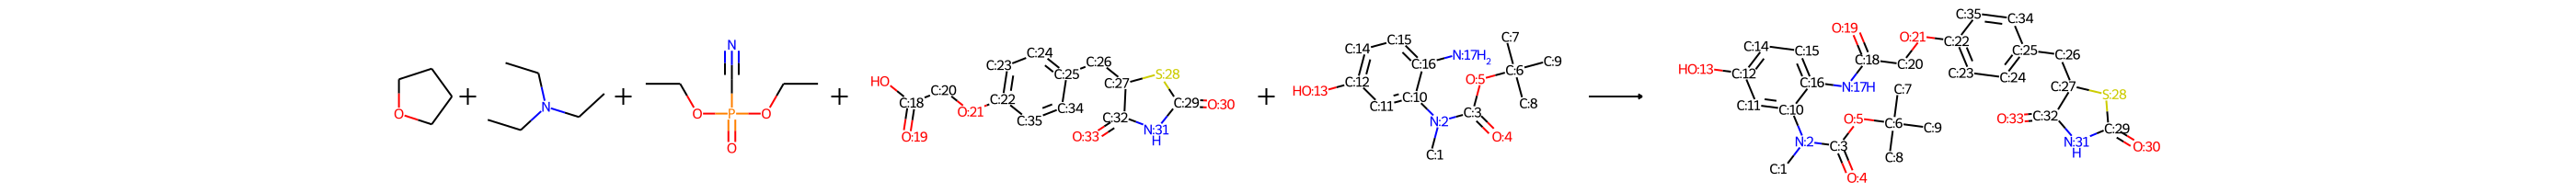

In [63]:
top = 1
numrxns = 3
indstart = (top-1)*numrxns
for i in range(indstart,indstart+numrxns):
    display(Chem.Draw.ReactionToImage(AllChem.ReactionFromSmarts(rxn[i], useSmiles=True), subImgSize=(400, 210)))
    print('')
    

### 0.1.3 Top 2 reaction template // Amide bond formation (COCl + NX2H -> CONX2)

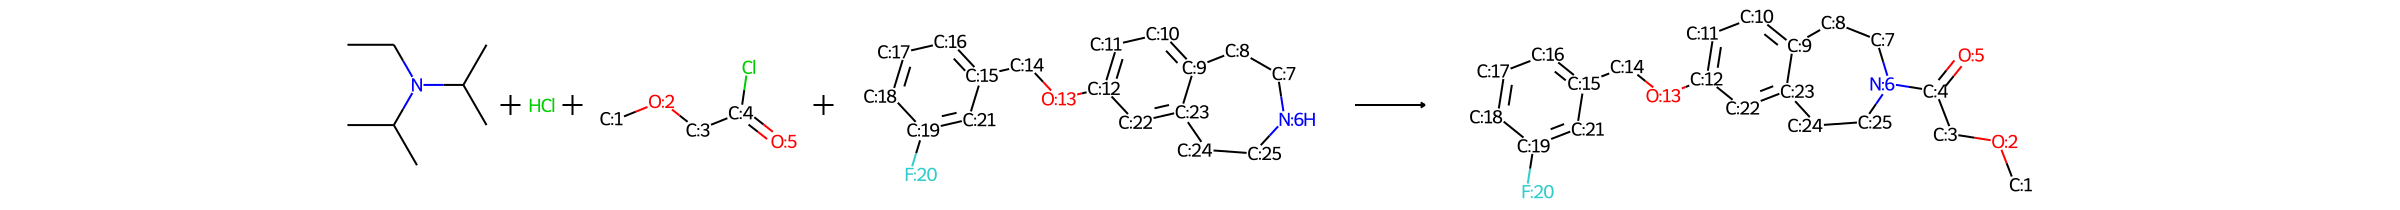

--------------------------------------------------------------------------------------------------------------------


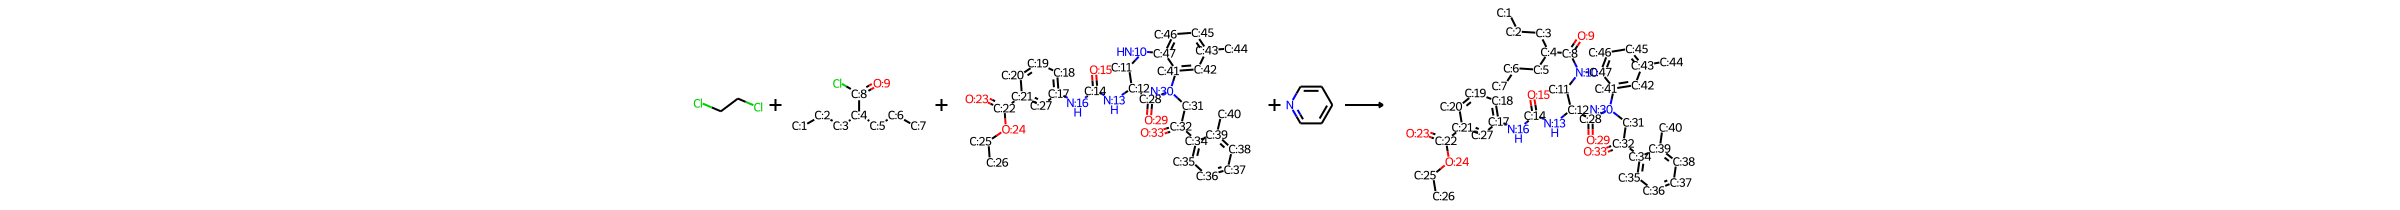

--------------------------------------------------------------------------------------------------------------------


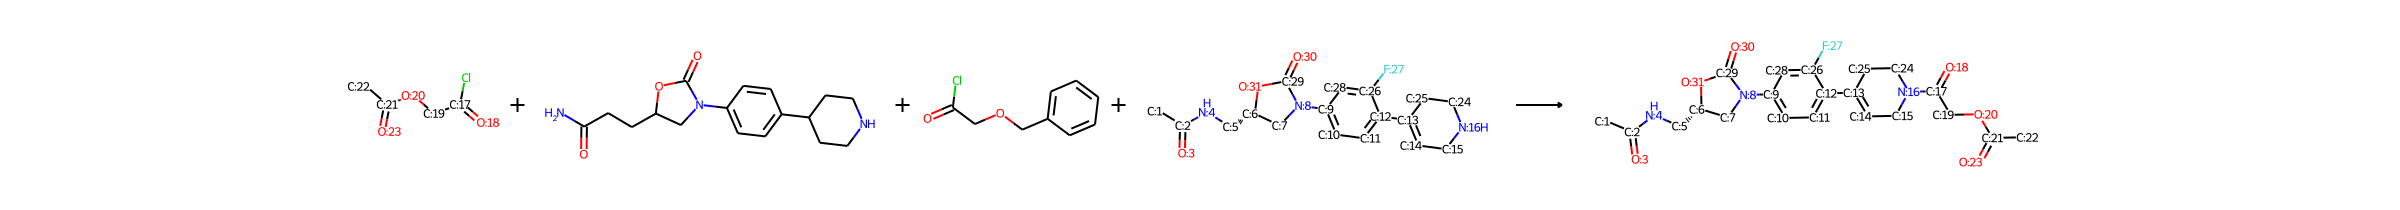

--------------------------------------------------------------------------------------------------------------------


In [64]:
top = 2
numrxns = 3
indstart = (top-1)*numrxns
for i in range(indstart,indstart+numrxns):
    display(Chem.Draw.ReactionToImage(AllChem.ReactionFromSmarts(rxn[i], useSmiles=True), subImgSize=(400, 210)))
    print('--------------------------------------------------------------------------------------------------------------------')


### 0.1.4 Top 3 reaction template // Amination/SN (R2CCl + NX2 -> R2CNX2) 

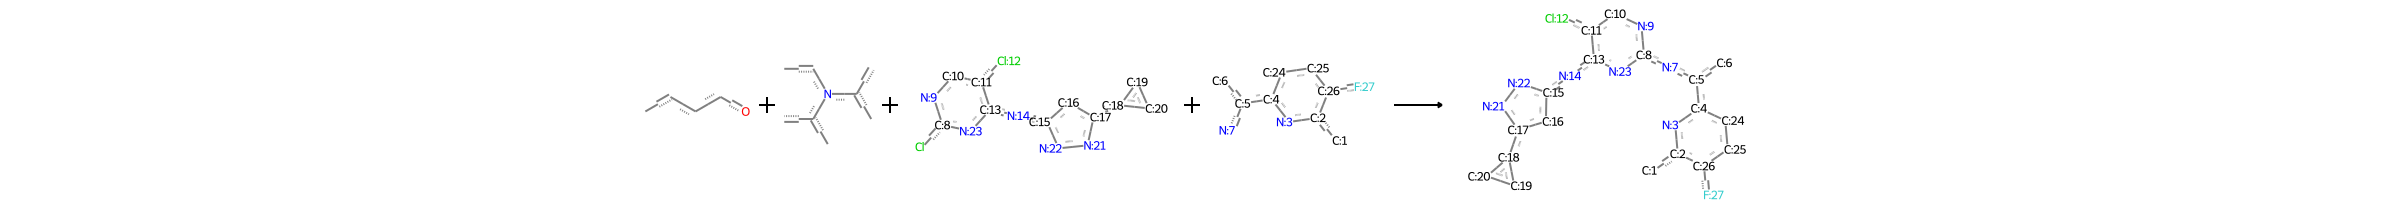

--------------------------------------------------------------------------------------------------------------------


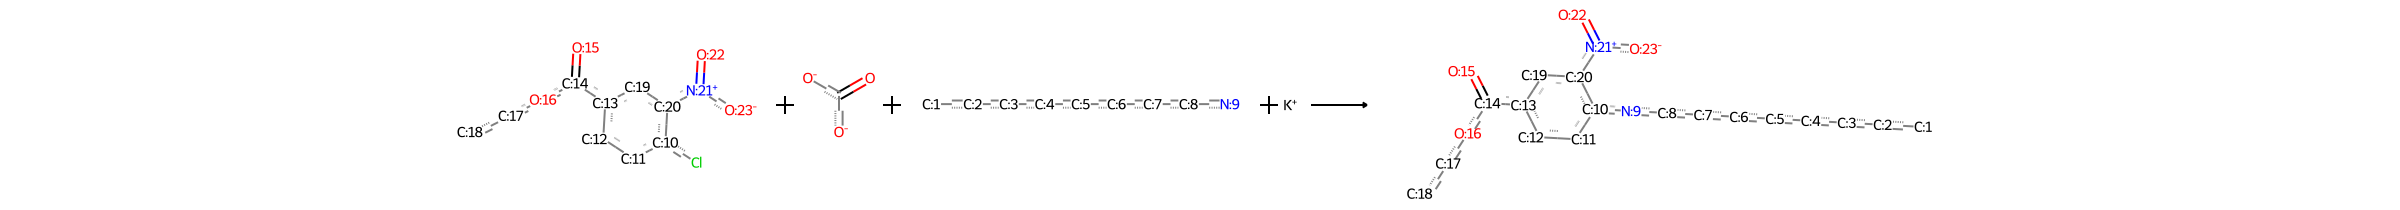

--------------------------------------------------------------------------------------------------------------------


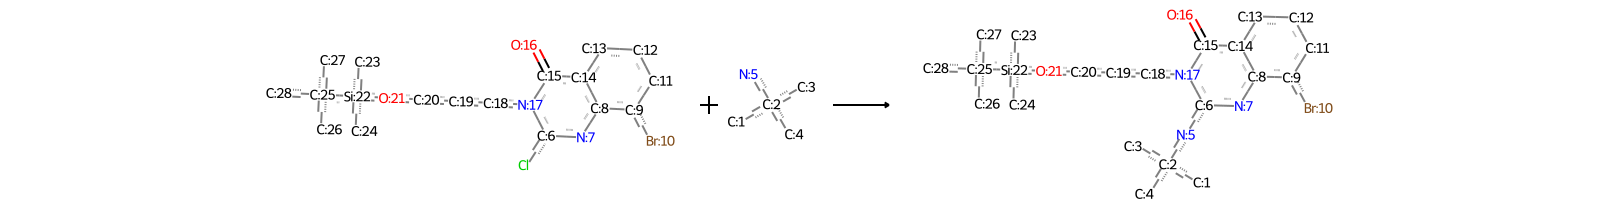

--------------------------------------------------------------------------------------------------------------------


In [59]:
top = 3
numrxns = 3
indstart = (top-1)*numrxns
for i in range(indstart,indstart+numrxns):
    display(Chem.Draw.ReactionToImage(AllChem.ReactionFromSmarts(rxn[i], useSmiles=True), subImgSize=(400, 210)))
    print('--------------------------------------------------------------------------------------------------------------------')

### 0.1.5 Top 4 reaction template // Demethylation of methyl ethers

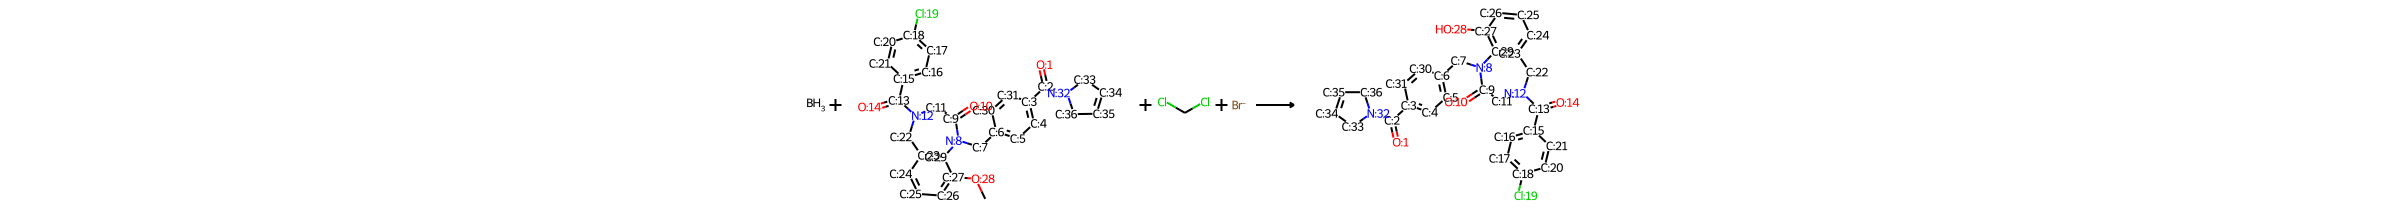

--------------------------------------------------------------------------------------------------------------------


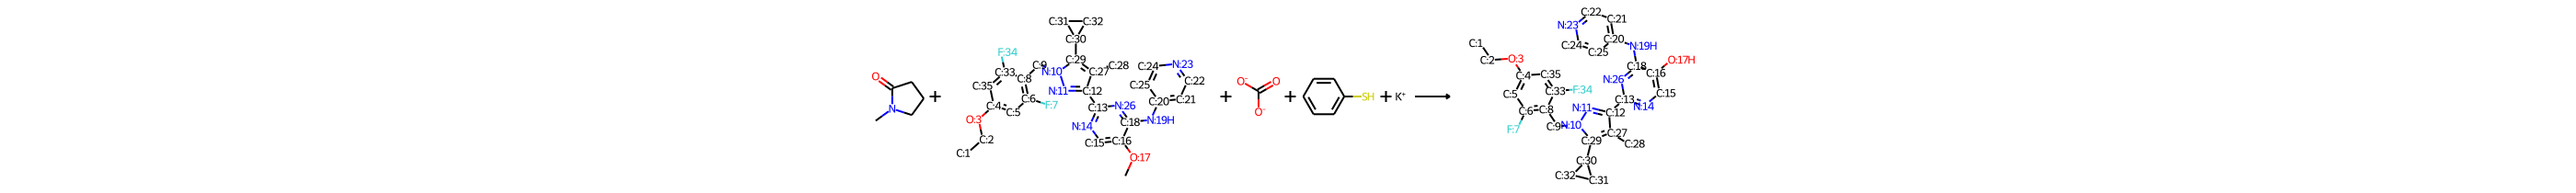

--------------------------------------------------------------------------------------------------------------------


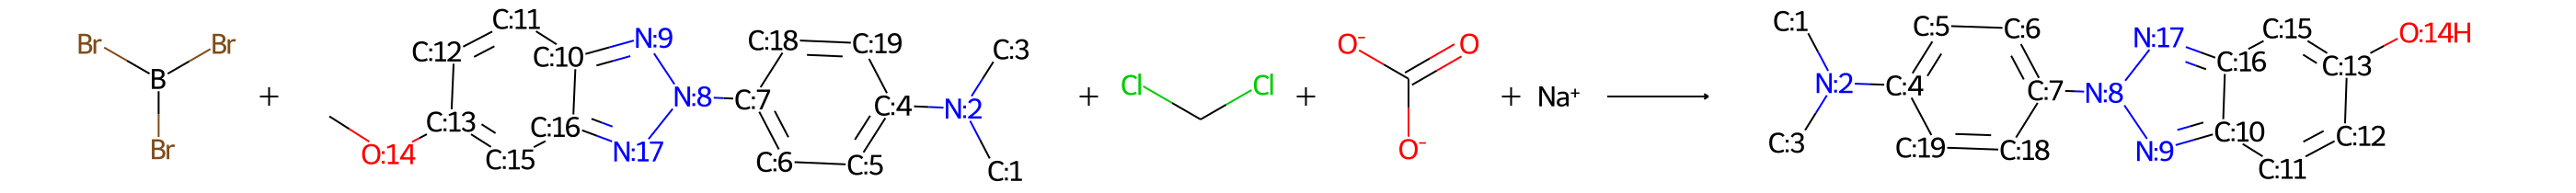

--------------------------------------------------------------------------------------------------------------------


In [65]:
top = 4
numrxns = 3
indstart = (top-1)*numrxns
for i in range(indstart,indstart+numrxns):
    display(Chem.Draw.ReactionToImage(AllChem.ReactionFromSmarts(rxn[i], useSmiles=True), subImgSize=(400, 210)))
    print('--------------------------------------------------------------------------------------------------------------------')

### 0.1.6 Top 5 reaction template // Addition of amine to carbonyl (RC=O + NR2 -> RC-NR2)

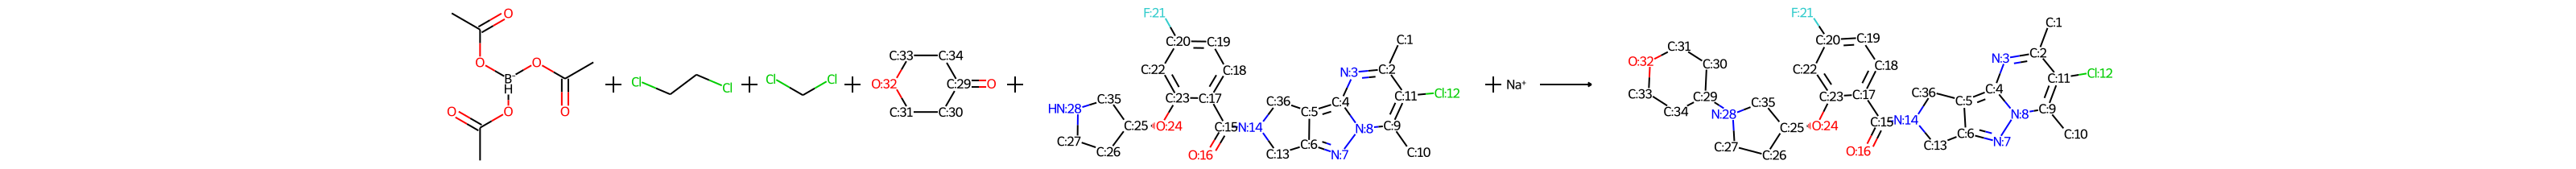

--------------------------------------------------------------------------------------------------------------------


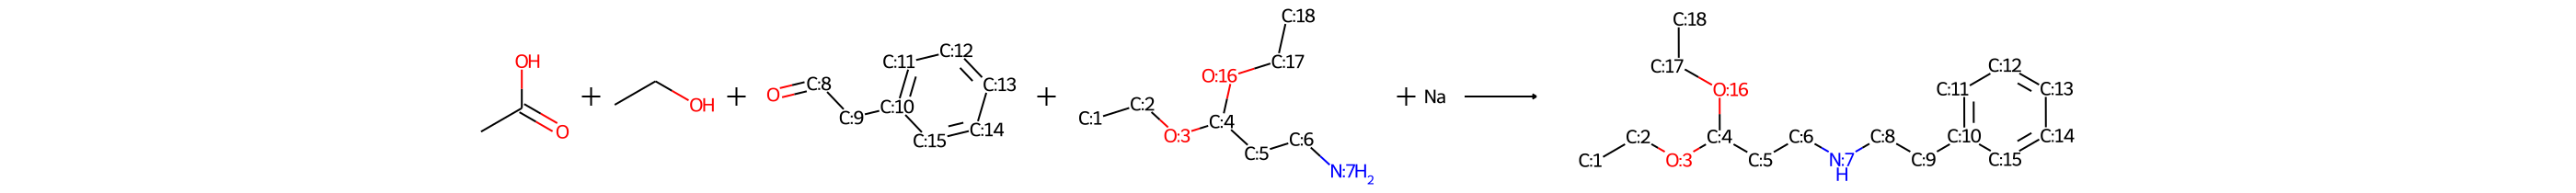

--------------------------------------------------------------------------------------------------------------------


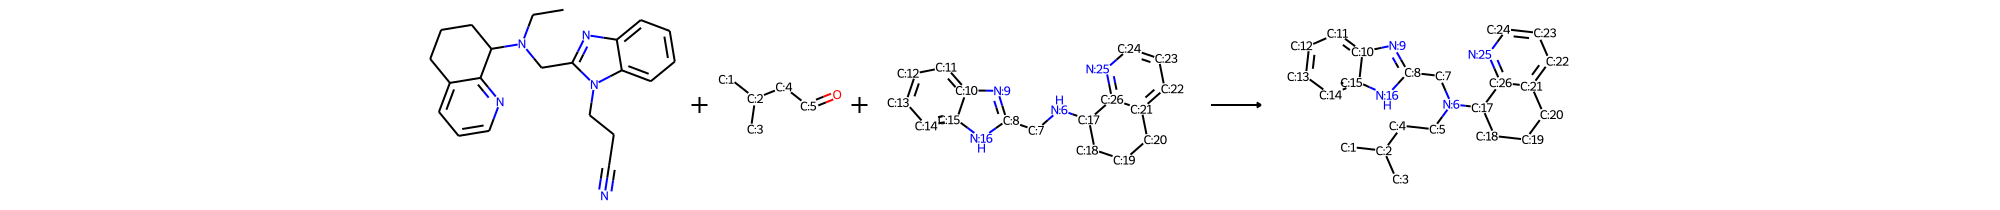

--------------------------------------------------------------------------------------------------------------------


In [66]:
top = 5
numrxns = 3
indstart = (top-1)*numrxns
for i in range(indstart,indstart+numrxns):
    display(Chem.Draw.ReactionToImage(AllChem.ReactionFromSmarts(rxn[i], useSmiles=True), subImgSize=(400, 210)))
    print('--------------------------------------------------------------------------------------------------------------------')

### 0.1.7 Top 6 reaction template // Reduction of aromatic nitro group (R(N+)OO -> RN)

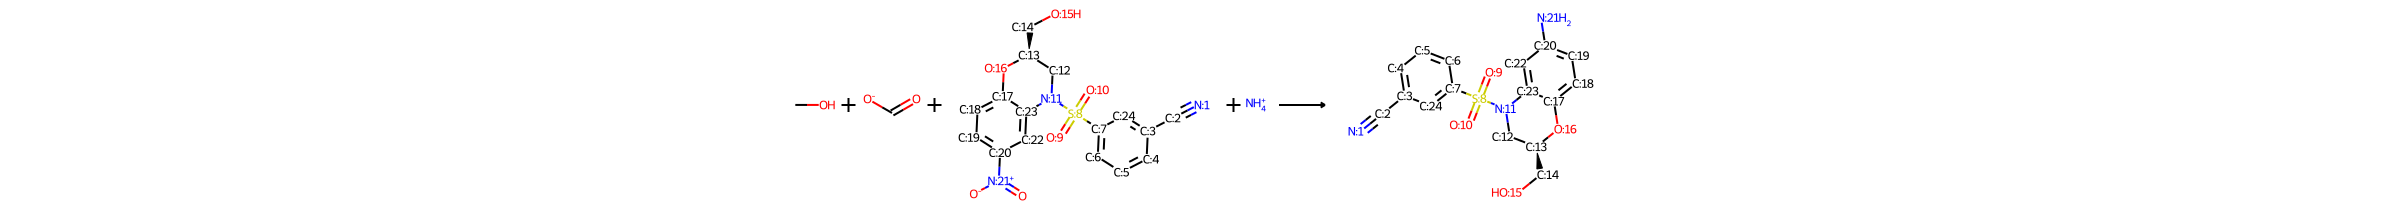

--------------------------------------------------------------------------------------------------------------------


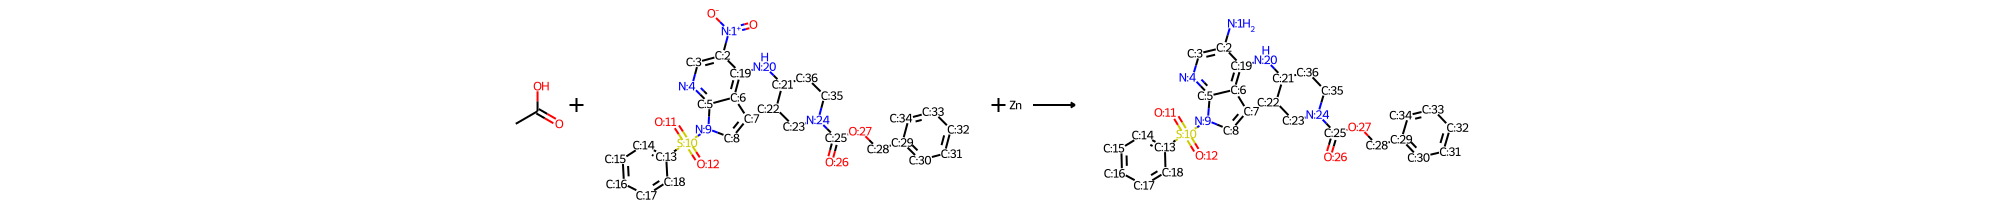

--------------------------------------------------------------------------------------------------------------------


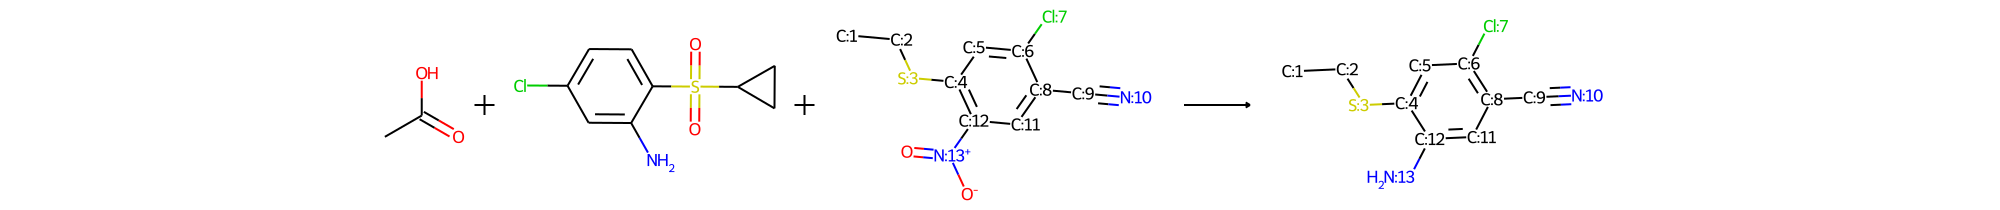

--------------------------------------------------------------------------------------------------------------------


In [67]:
top = 6
numrxns = 3
indstart = (top-1)*numrxns
for i in range(indstart,indstart+numrxns):
    display(Chem.Draw.ReactionToImage(AllChem.ReactionFromSmarts(rxn[i], useSmiles=True), subImgSize=(400, 210)))
    print('--------------------------------------------------------------------------------------------------------------------')

### 0.1.8 Top 7 reaction template // Boc deprotection

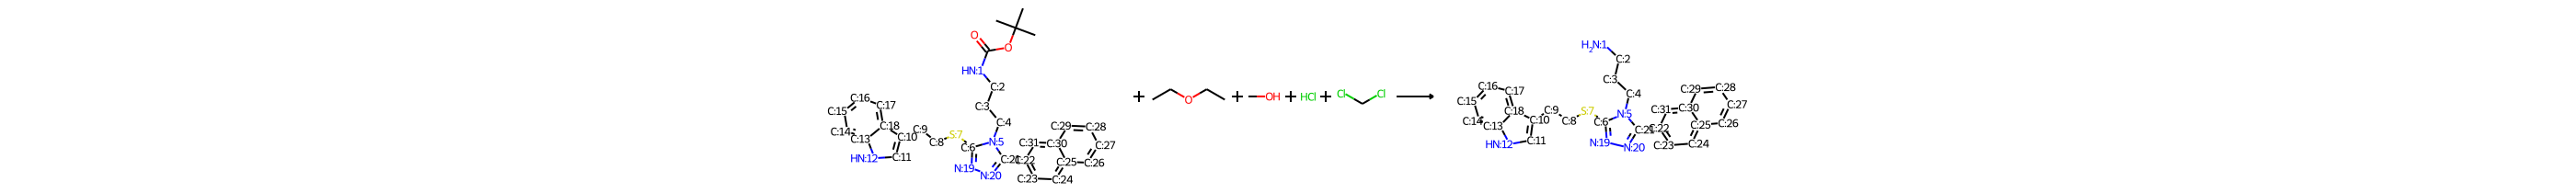

--------------------------------------------------------------------------------------------------------------------


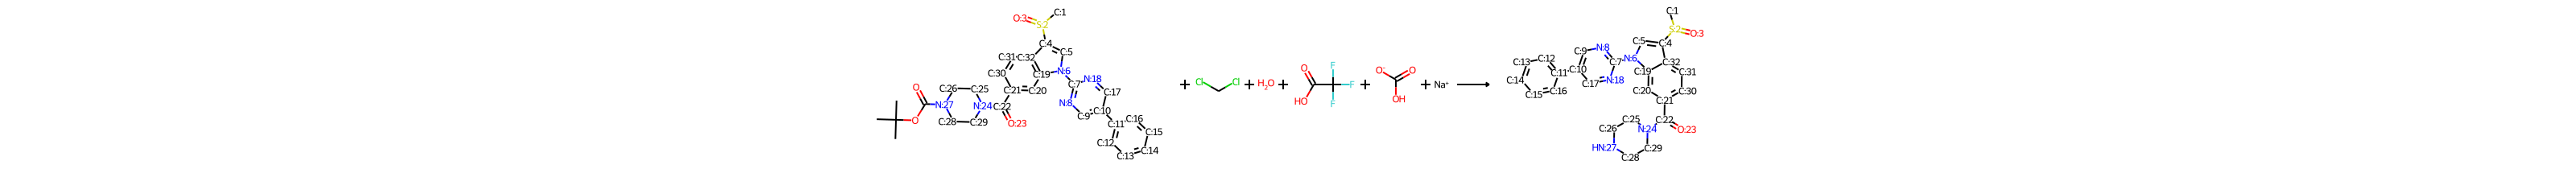

--------------------------------------------------------------------------------------------------------------------


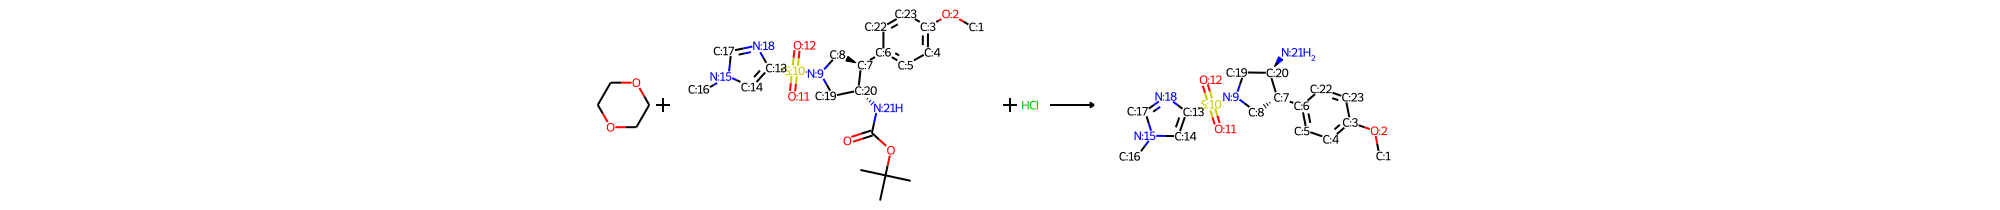

--------------------------------------------------------------------------------------------------------------------


In [68]:
top = 7
numrxns = 3
indstart = (top-1)*numrxns
for i in range(indstart,indstart+numrxns):
    display(Chem.Draw.ReactionToImage(AllChem.ReactionFromSmarts(rxn[i], useSmiles=True), subImgSize=(400, 210)))
    print('--------------------------------------------------------------------------------------------------------------------')

### 0.1.9 Top 8 reaction template // Hydrolysis of esters

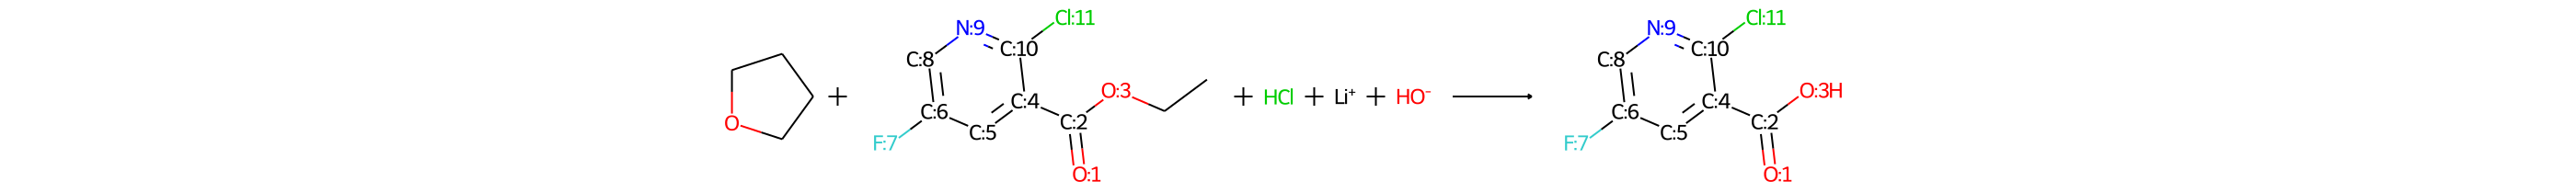

--------------------------------------------------------------------------------------------------------------------


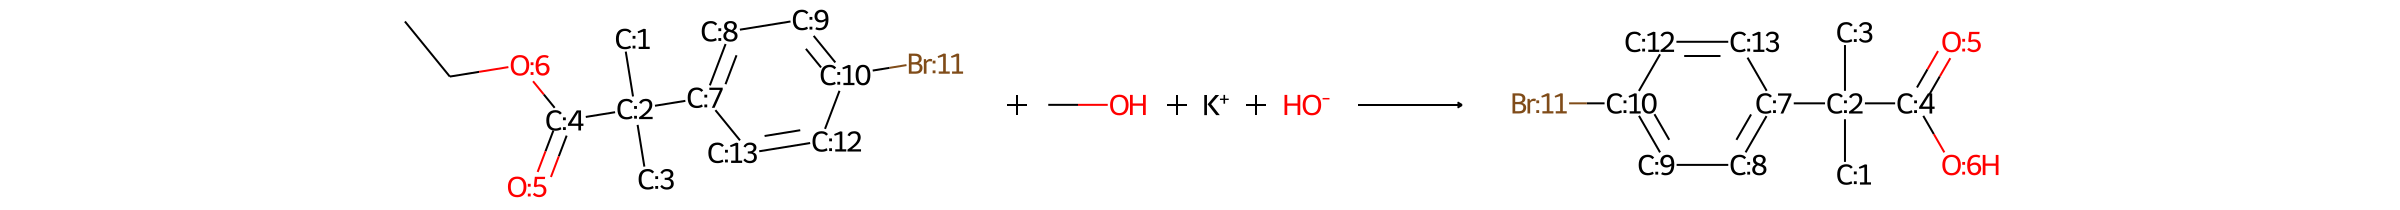

--------------------------------------------------------------------------------------------------------------------


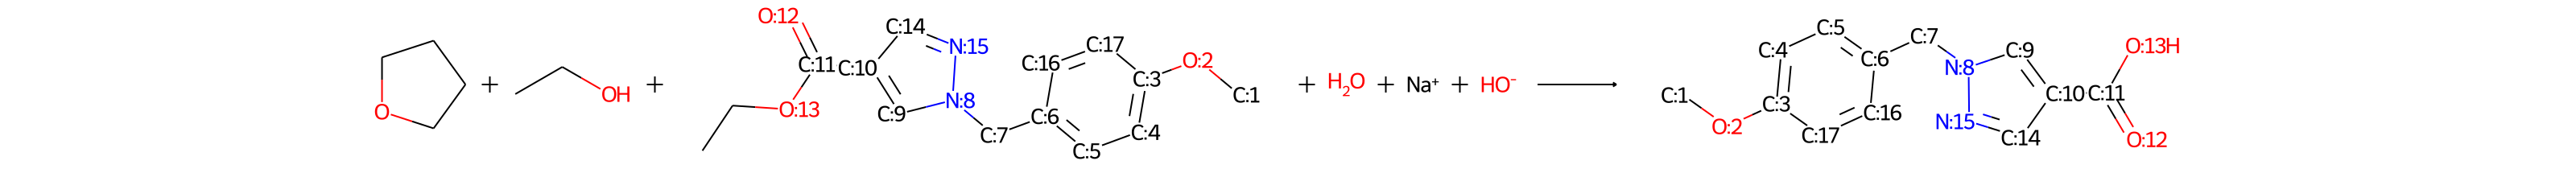

--------------------------------------------------------------------------------------------------------------------


In [69]:
top = 8
numrxns = 3
indstart = (top-1)*numrxns
for i in range(indstart,indstart+numrxns):
    display(Chem.Draw.ReactionToImage(AllChem.ReactionFromSmarts(rxn[i], useSmiles=True), subImgSize=(400, 210)))
    print('--------------------------------------------------------------------------------------------------------------------')

### 0.1.10 Top 9 reaction template // Allylation of alcohols

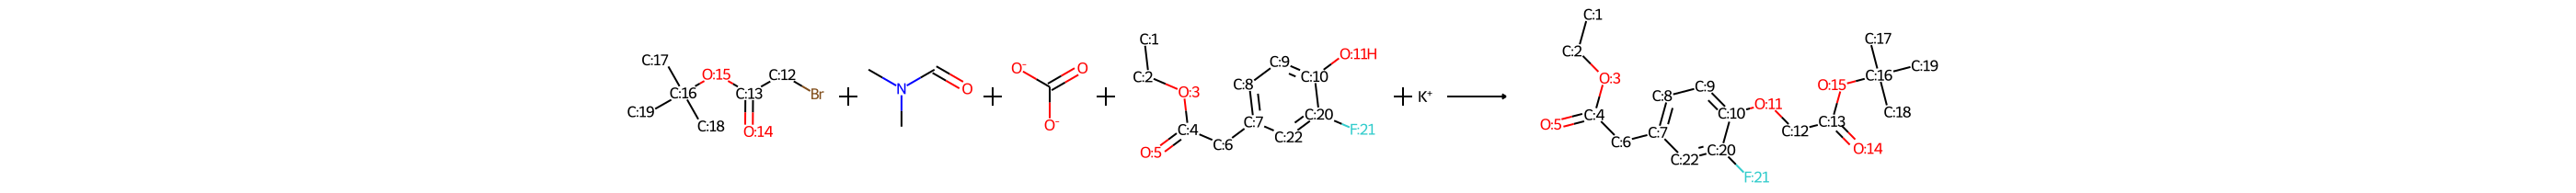

--------------------------------------------------------------------------------------------------------------------


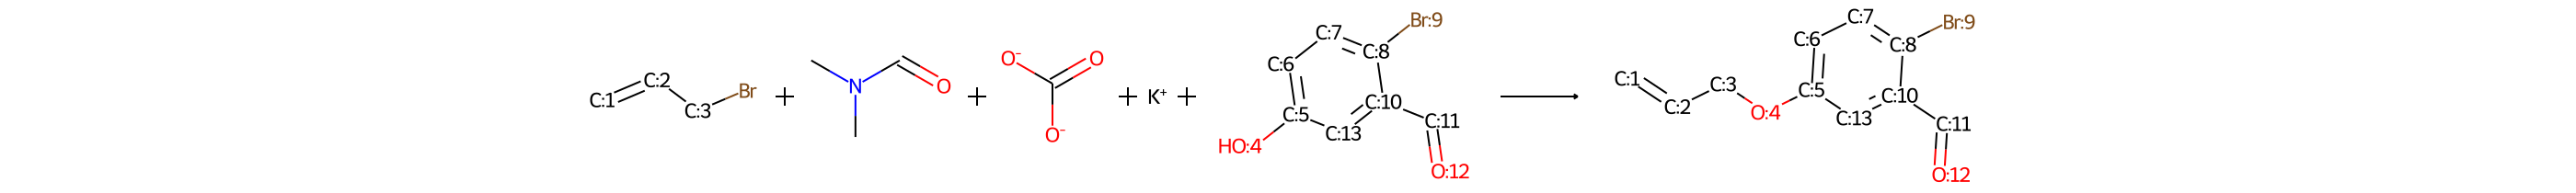

--------------------------------------------------------------------------------------------------------------------


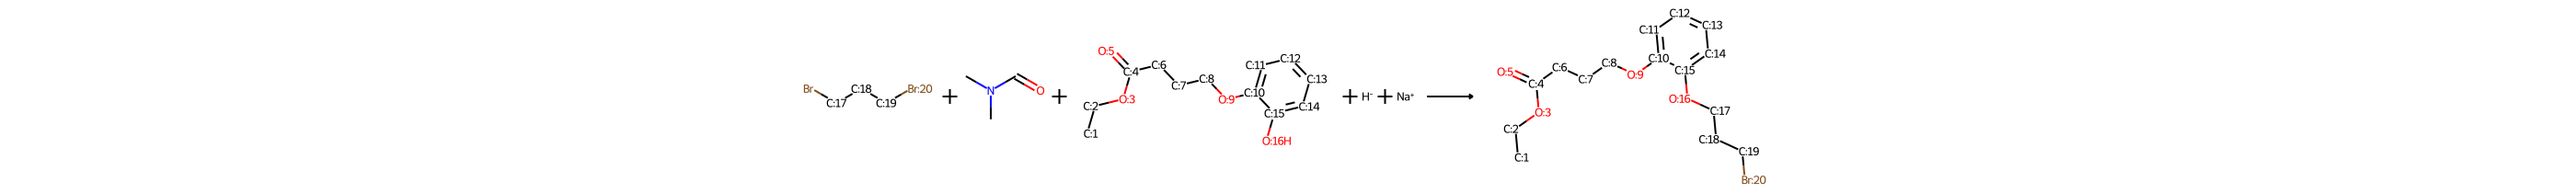

--------------------------------------------------------------------------------------------------------------------


In [70]:
top = 9
numrxns = 3
indstart = (top-1)*numrxns
for i in range(indstart,indstart+numrxns):
    display(Chem.Draw.ReactionToImage(AllChem.ReactionFromSmarts(rxn[i], useSmiles=True), subImgSize=(400, 210)))
    print('--------------------------------------------------------------------------------------------------------------------')

### 0.1.11 Top 10 reaction template // Esterification 

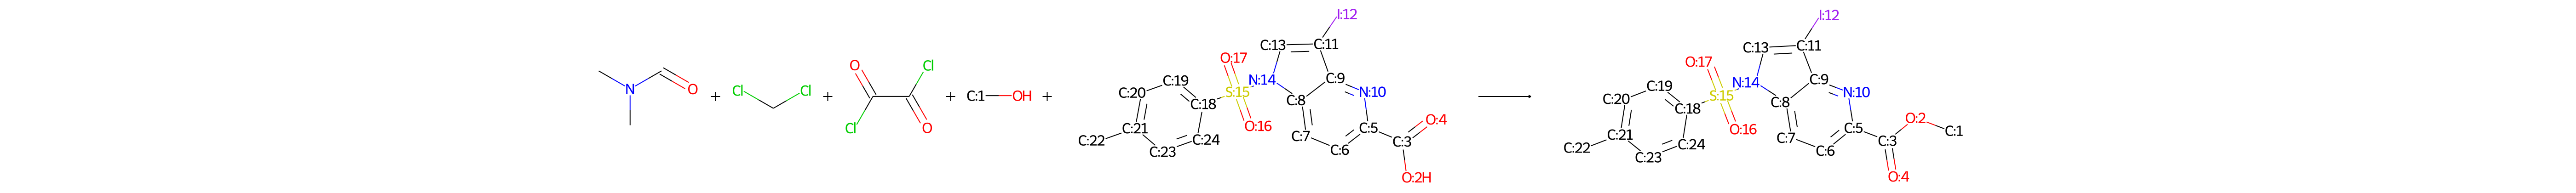

--------------------------------------------------------------------------------------------------------------------


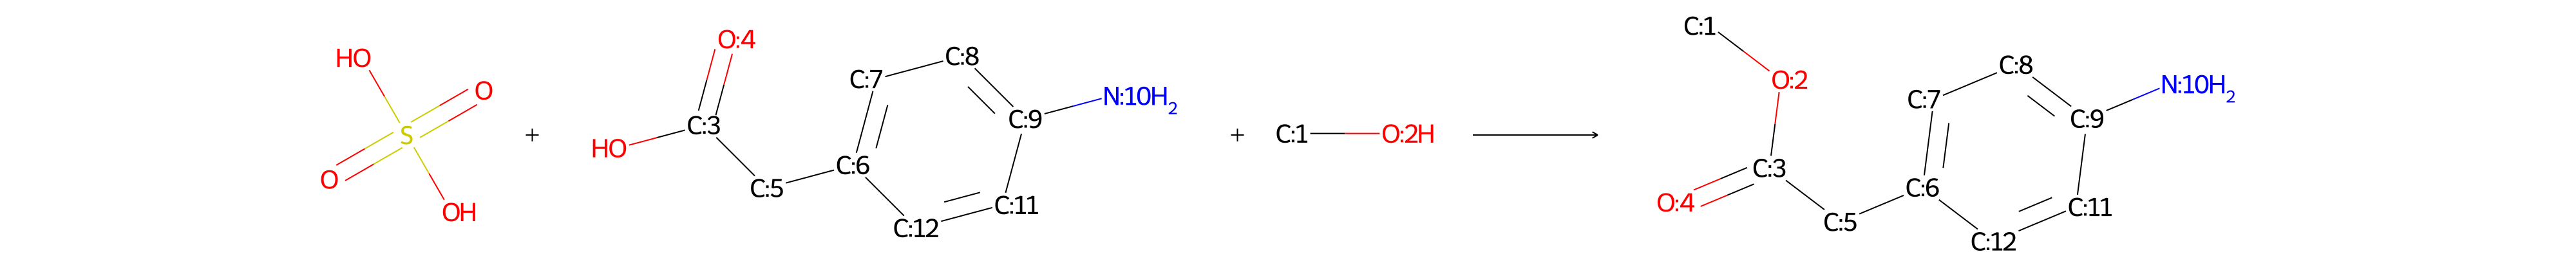

--------------------------------------------------------------------------------------------------------------------


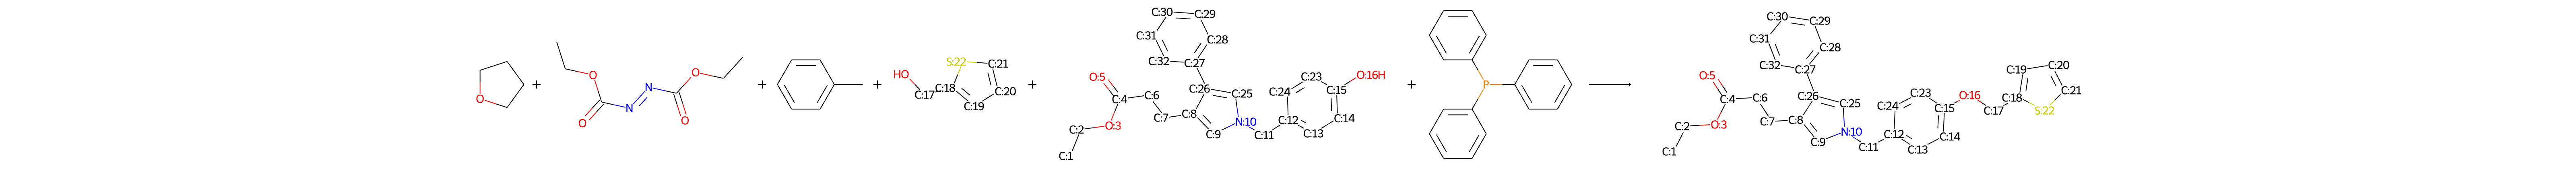

--------------------------------------------------------------------------------------------------------------------


In [71]:
top = 10
numrxns = 3
indstart = (top-1)*numrxns
for i in range(indstart,indstart+numrxns):
    display(Chem.Draw.ReactionToImage(AllChem.ReactionFromSmarts(rxn[i], useSmiles=True), subImgSize=(800, 420)))
    print('--------------------------------------------------------------------------------------------------------------------')

### 0.1.12 Top 11 reaction template // SN1 displacement with nitrogen 

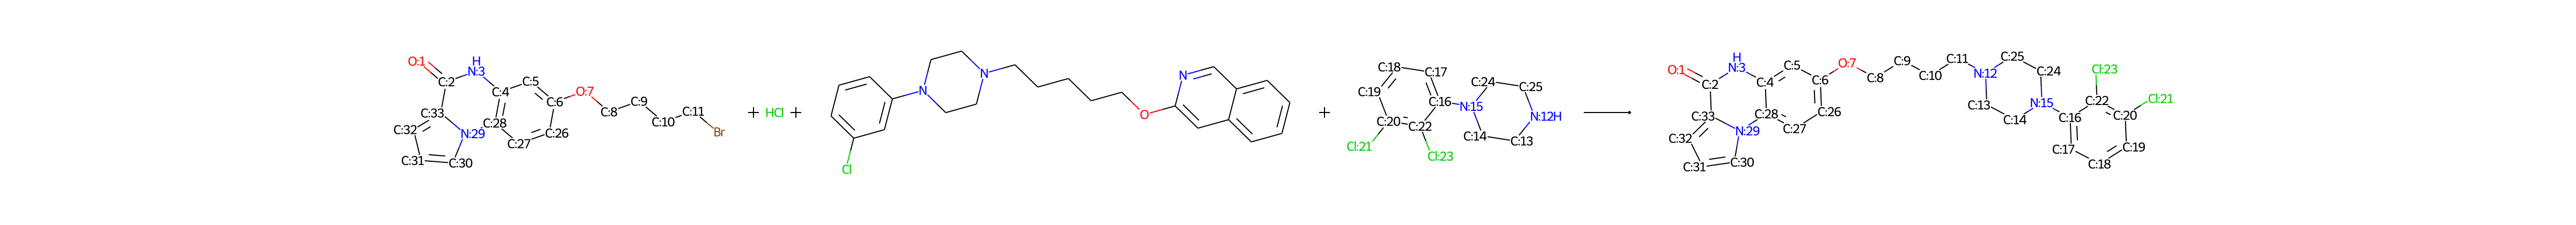

--------------------------------------------------------------------------------------------------------------------


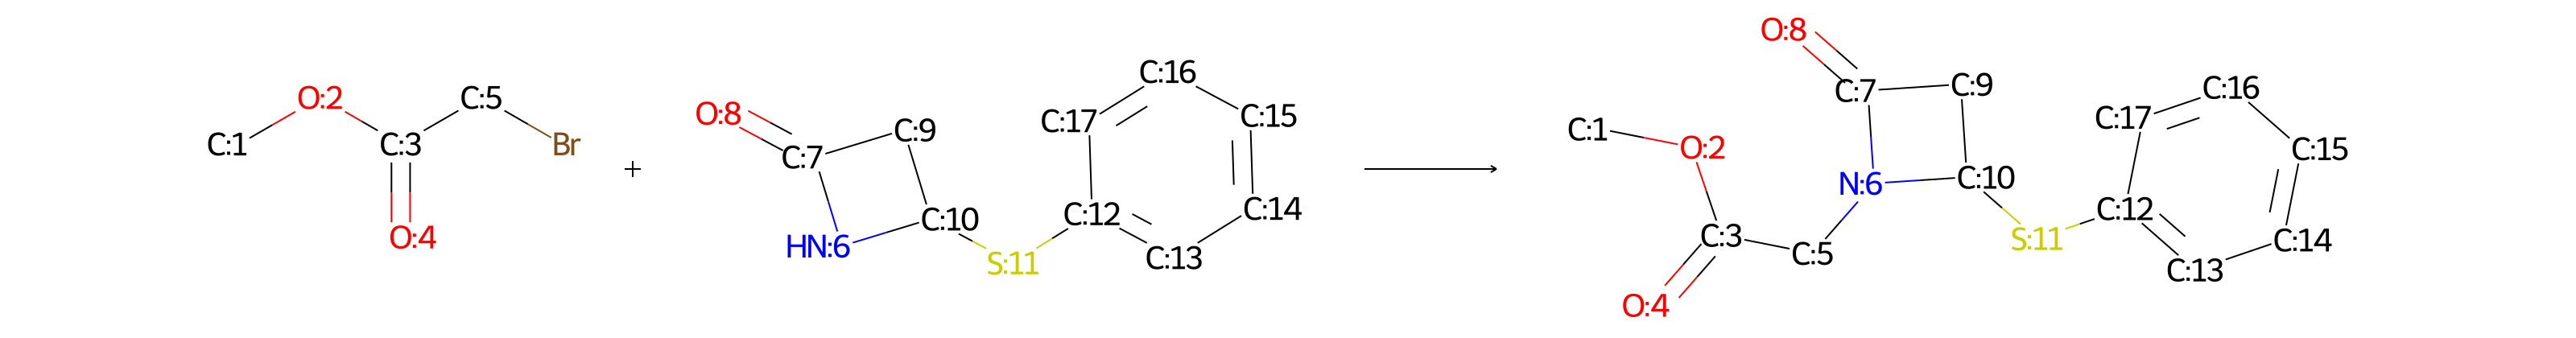

--------------------------------------------------------------------------------------------------------------------


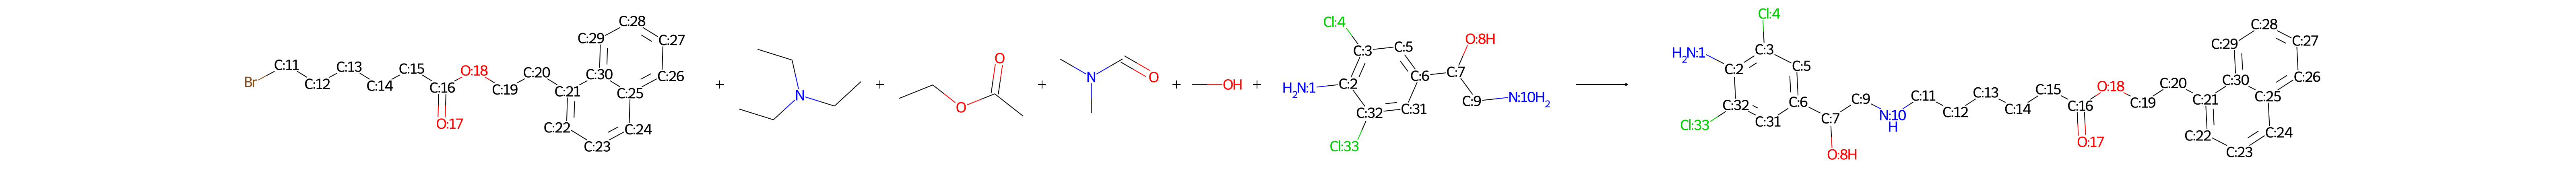

--------------------------------------------------------------------------------------------------------------------


In [72]:
top = 11
numrxns = 3
indstart = (top-1)*numrxns
for i in range(indstart,indstart+numrxns):
    display(Chem.Draw.ReactionToImage(AllChem.ReactionFromSmarts(rxn[i], useSmiles=True), subImgSize=(800, 420)))
    print('--------------------------------------------------------------------------------------------------------------------')

### 0.1.13 Top 10 reaction template // Sulfonylation of nitrogen

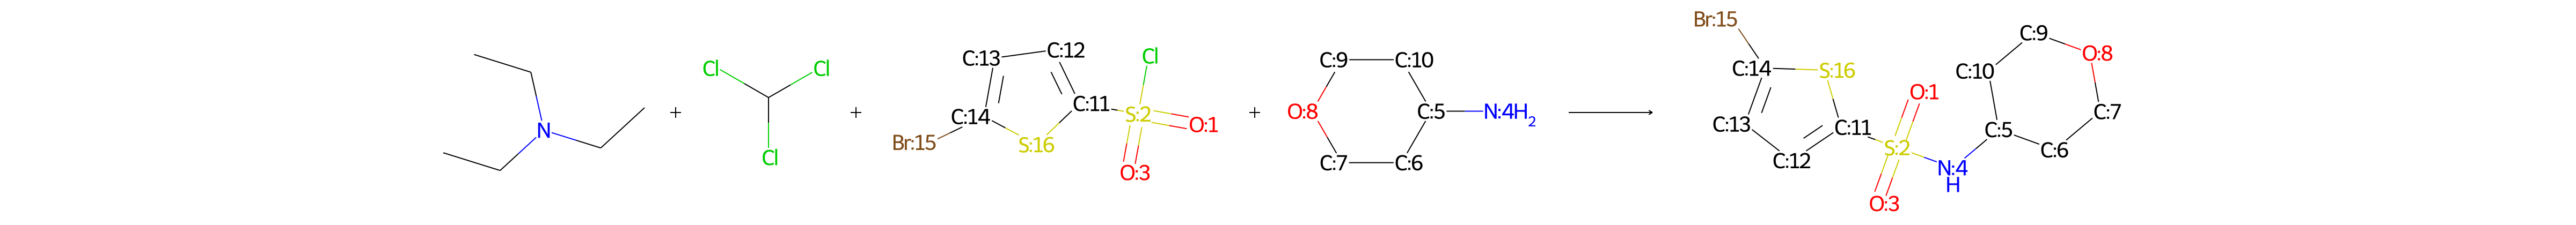

--------------------------------------------------------------------------------------------------------------------


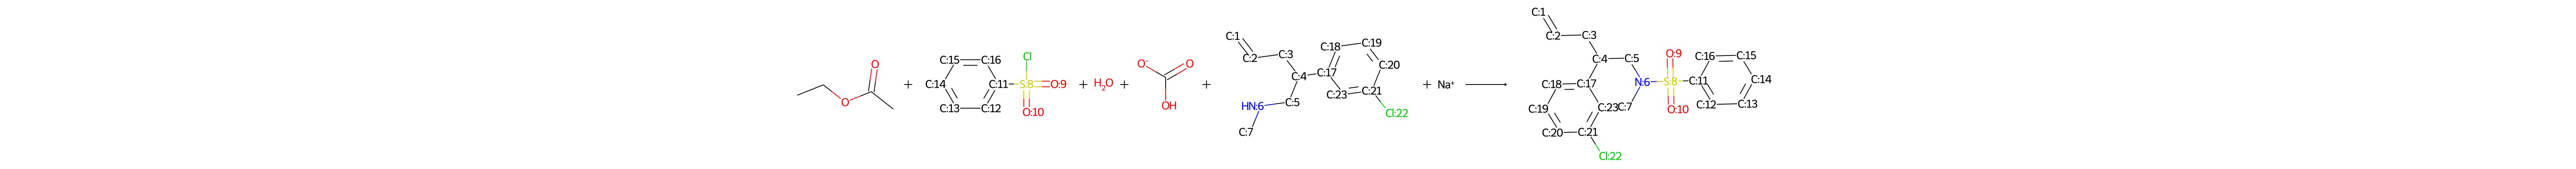

--------------------------------------------------------------------------------------------------------------------


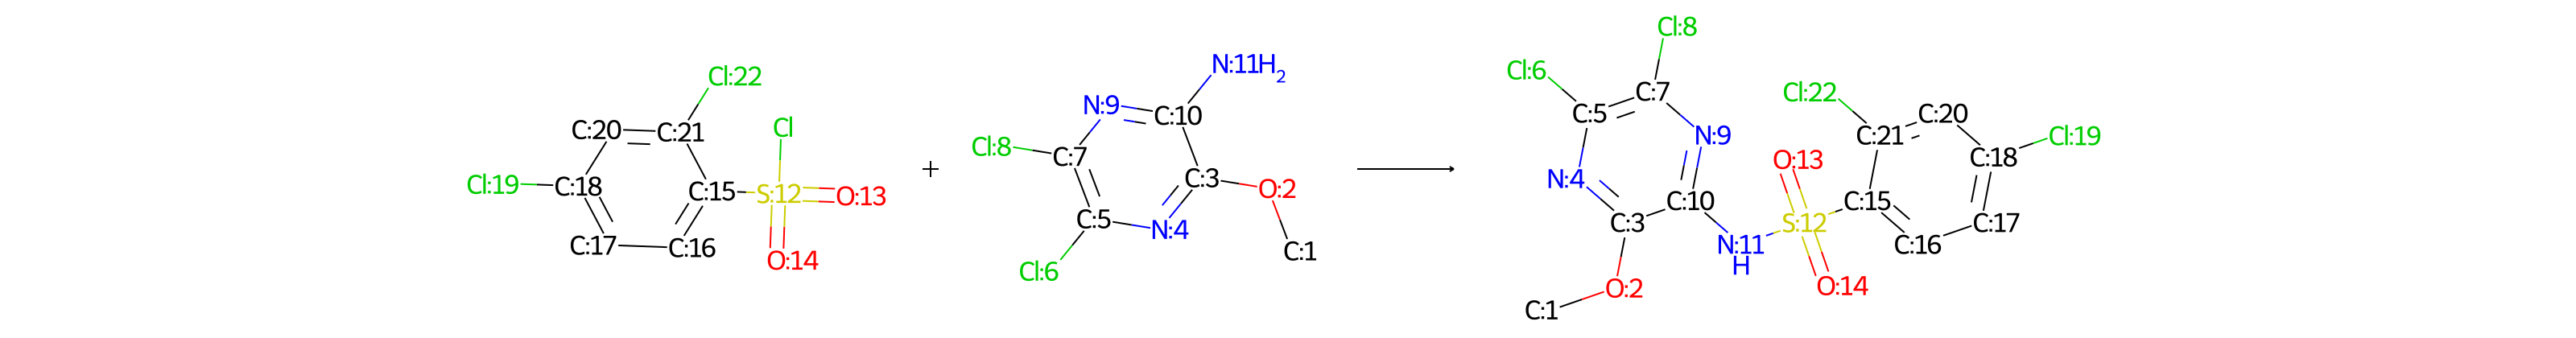

--------------------------------------------------------------------------------------------------------------------


In [73]:
#Sulfonylation of nitrogen
top = 12
numrxns = 3
indstart = (top-1)*numrxns
for i in range(indstart,indstart+numrxns):
    display(Chem.Draw.ReactionToImage(AllChem.ReactionFromSmarts(rxn[i], useSmiles=True), subImgSize=(800, 420)))
    print('--------------------------------------------------------------------------------------------------------------------')

## 0.2 Beckmann rearrangements

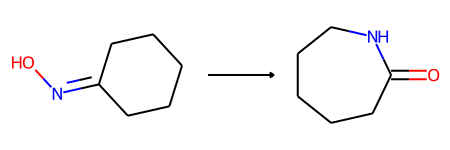

In [75]:
## Beckmann rearrangement
AllChem.ReactionFromSmarts('O/N=C1CCCCC/1>>O=C1NCCCCC1', useSmiles = True)

In [89]:
Beckmanns = ['O/N=C1CCCCC/1>>O=C1NCCCCC1','O/N=C1CCCC/1>>O=C1NCCCC1']

In [83]:
mapped_reactions = ['[OH:1][N:8]=[C:2]1[CH2:3][CH2:4][CH2:5][CH2:6][CH2:7]1>>[O:1]=[C:2]1[CH2:3][CH2:4][CH2:5][CH2:6][CH2:7][NH:8]1',
                    '[OH:1][N:7]=[C:2]1[CH2:3][CH2:4][CH2:5][CH2:6]1>>[O:1]=[C:2]1[CH2:3][CH2:4][CH2:5][CH2:6][NH:7]1']

In [86]:
df_test['rsmi'] = mapped_reactions
df_test['patent_id'] = mapped_reactions
df_test['para_num'] = 0
df_test['year'] = 2023
df_test['classification'] = ''
df_test['text_yield'] = 0
df_test['calc_yield'] = 0

In [88]:
df_test.to_csv('/home/yves/Documents/GitHub/CASP-and-dataset-performance/data-hiding-place/Beckmann_reactions.csv', index=False)

In [96]:
Beckmann_r0 = pd.read_csv('/home/yves/Documents/GitHub/CASP-and-dataset-performance/outputs/amol_USPTO_templates_Beckmann.csv', header=None)
Beckmann_r0.columns = ["ind","ID", "reaction_hash", "reactants", "products", "classification","retro_template", "template_hash", "selectivity", "outcomes"]
Beckmann_r0.drop(columns=['ind'], inplace=True)


In [98]:
Beckmann_r0.to_pickle('/home/yves/Documents/GitHub/CASP-and-dataset-performance/results/Beckmann_2rxns.pkl')


In [100]:
Beckmann_r0['retro_template'].unique()

array(['([CH2;D2;+0:1]-[NH;D2;+0:3]-[C;H0;D3;+0:2]=[O;H0;D1;+0:4])>>([CH2;D2;+0:1]-[C;H0;D3;+0:2]=[N;H0;D2;+0:3]-[OH;D1;+0:4])'],
      dtype=object)

# 1 General templates investigation

## 1.1 Template frequency introdution

In [74]:
appearances_hash_r0#/len(temp_r0)*100

46c5bf4df09441d4931d8afec7832e2172f32d481ef7ed4f6564aaf3    83489
f1a50309dc25b25b97cd34f22b9e0e615db1f43409ced22190fba0e1    44557
d3b709dc5d81b0874732468cbe918e45ef05da047417d2e0b0781fbb    34997
e47a6bcf7282afc3a6a39e4104b8a0774e04e27fb968a84a03130ac0    29326
257695620b51d5d5ae1a3d66359b6e5442388ac47e8edd50c336b736    22604
                                                            ...  
5b3ed62d59a8dfab63671ff4748a91dfa192f911f6d1bb1110bd9bd2        1
dc4d51e8f5780fa1229b3b7fec093fed1079c4aa5649e8d8ef7e1111        1
4cff7e4c72bc297002bcafe01092cf41c6e4f91aa0a73c2cf60d71c5        1
8adc6b2b09b7a949c20e0c5383a6395c7925fdbbd64f0f5c567676e7        1
24f98a67a6a57fa69c07b1382d93853a9ac5bd923f7bf99a48d2f325        1
Name: template_hash, Length: 137500, dtype: int64

In [80]:
cumsum = 0
for i in range(1347):
    cumsum += appearances_hash_r0[i]
cumsum, cumsum/len(temp_r0)


(909425, 0.7644565228355564)

In [81]:
num_1rxn = len([i for i in range(len(appearances_hash_r0)) if appearances_hash_r0[i] == 1])

In [82]:
(len(temp_r0)-cumsum-num_1rxn)/len(temp_r0)

0.1482058377520519

In [83]:
appearances_hash_r0[0]

83489

In [84]:
#number of distinct not unique templates 
len([i for i in range(len(appearances_hash_r0)) if appearances_hash_r0[i] > 1])

33600

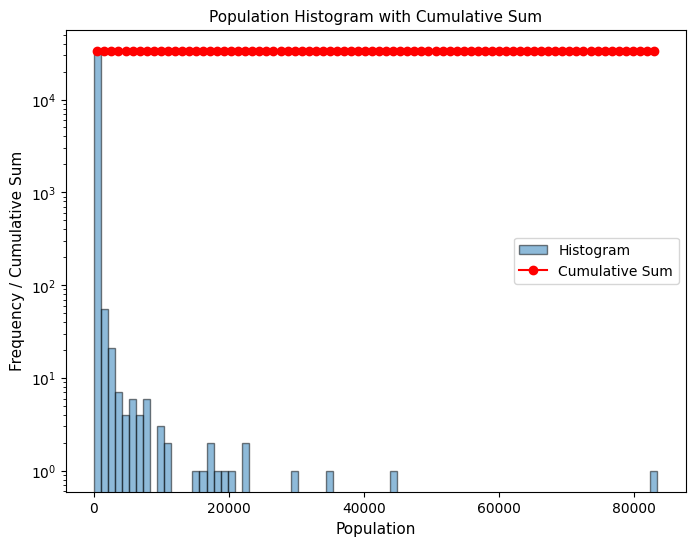

In [85]:
#distribution of templates frequencies by number of template appearances (>1) (whole set) bin size 1000
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

data = [appearances_hash_r0[i] for i in range(len(appearances_hash_r0)) if appearances_hash_r0[i] > 1]
num_bins = 80

plt.figure(figsize=(8, 6))
# Create the histogram
hist, bin_edges = np.histogram(data, bins=num_bins)

# Compute the cumulative sum of the histogram values
cumulative_sum = np.cumsum(hist)

# Create the histogram plot
plt.hist(data, bins=num_bins, edgecolor='k', alpha=0.5, label='Histogram')

# Create the cumulative sum plot
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_centers, cumulative_sum, '-o', color='r', label='Cumulative Sum')

# Customize the plot
plt.xlabel('Population', fontsize=11)
plt.ylabel('Frequency / Cumulative Sum', fontsize=11)
plt.title('Population Histogram with Cumulative Sum', fontsize=11, fontstyle='normal')
plt.legend()

plt.yscale('log')
# Display the plot
plt.show()

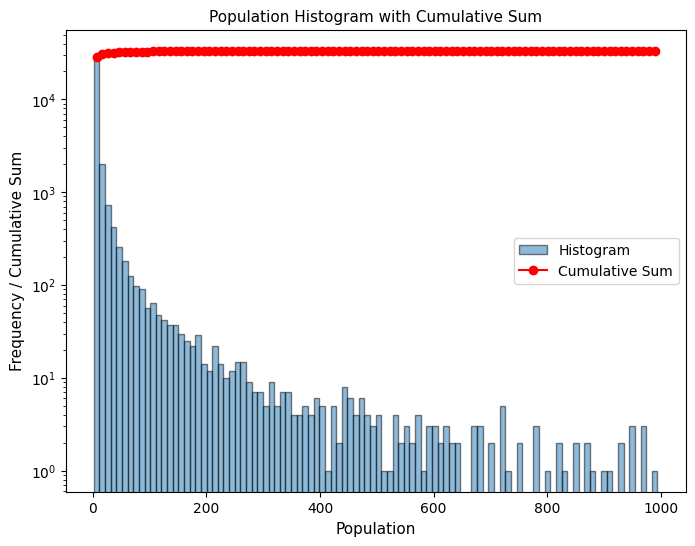

In [86]:
#distribution of templates frequencies by number of template appearances (>1) (0 to 1000 template appearancies) bin size 10
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

data = [appearances_hash_r0[i] for i in range(len(appearances_hash_r0)) if appearances_hash_r0[i] > 1 and appearances_hash_r0[i] < 1000]
num_bins = 100

plt.figure(figsize=(8, 6))

# Create the histogram
hist, bin_edges = np.histogram(data, bins=num_bins)

# Compute the cumulative sum of the histogram values
cumulative_sum = np.cumsum(hist)

# Create the histogram plot
plt.hist(data, bins=num_bins, edgecolor='k', alpha=0.5, label='Histogram')

# Create the cumulative sum plot
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_centers, cumulative_sum, '-o', color='r', label='Cumulative Sum')

# Customize the plot
plt.xlabel('Population', fontsize=11)
plt.ylabel('Frequency / Cumulative Sum', fontsize=11)
plt.title('Population Histogram with Cumulative Sum', fontsize=11, fontstyle='normal')
plt.legend()

plt.yscale('log')
# Display the plot
plt.show()

## 1.2 Estimation of enrichment strategy

In [7]:
#delete
#uspto length (only templates successfully extracted)
len(temp_r0)

1189636

In [8]:
sum([appearances_hash_r0[i] < 10000 for i in range(len(appearances_hash_r0))])

137484

In [13]:
min_app     = 20
target_app  = 5000

final_size = len(temp_r0)   # to see what the final size of the dataset would be after enrichment
num_rxn = 0                 #num of reaction templates for which an enrichment would be needed

for i in tqdm(range(len(appearances_hash_r0))):
    if appearances_hash_r0[i] > min_app and appearances_hash_r0[i] < target_app:
        final_size += (target_app - appearances_hash_r0[i])
        num_rxn += 1
final_size, num_rxn

100%|██████████| 137500/137500 [00:00<00:00, 935014.27it/s]


(14905904, 2830)